# Investigating $h(W)$
Recall the function $$h(W) = e^{W \circ W} - d,$$
where $\circ$ is the Hadamard product. 

We know that this is a measure for $\textit{acyclicness}$ of a weighted adjacency matrix $W$. In fact, we do know from Theorem 1 of the NOTEARS paper that
$$h(W) = 0 \iff \text{$W$ "is" a DAG}.$$
Now, a second question arises. Are there local minima that are not optimal? That is, does there exists a $\hat{W}$ such that $h(\hat{W}) \neq 0$, but $\nabla h(W) = 0?$

In [27]:
import numpy as np
import scipy.linalg as slin
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import helper.helper as helper

In [47]:
def h(W):
    """Evaluate value and gradient of acyclicity constraint."""
    
    E = slin.expm(W * W)  # (Zheng et al. 2018)
    h = np.trace(E) - np.shape(A)[0]
    G_h = E.T * W * 2
    
    return h, G_h

def h2(W):
    
    V = W - np.diag(np.diag(W))
    E = slin.expm(V * V) 
    h = np.trace(E) - np.shape(A)[0]
    G_h = E.T * V * 2
    
    return h, G_h

def h_2D(w12, w21):
    W = np.array([[0, w12], [w21, 0]])
    E = slin.expm(W * W) 
    h = np.trace(E) - np.shape(W)[0]
    G_h = E.T * W * 2
    
    return h, G_h

In [3]:
# Generate a matrix
A = np.array([[1.0, 0.0], [0.0, 1.0]])
print(round(h(A)[0], 2), round(h2(A)[0], 2), round(h_2D(0.1, 0.2)[0], 2))

3.44 0.0 0.0


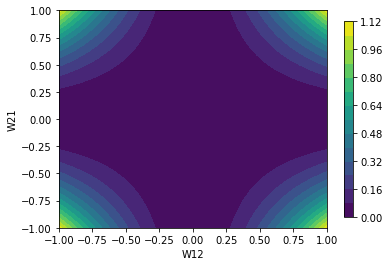

In [48]:
num = 50

w12, w21 = np.linspace(-1, 1, num), np.linspace(-1, 1, num)
W12, W21 = np.meshgrid(w12, w21)

Z = np.zeros((num, num))

for i in range(num):
    for j in range(num):
        Z[i][j] = h_2D(w12[i], w21[j])[0]
        
fig, ax = plt.subplots(1)
cs = ax.contourf(W12, W21, Z, levels = 15)
fig.colorbar(cs, ax=ax, shrink=0.9)

plt.xlabel("W12")
plt.ylabel("W21")

plt.show()

$\textbf{Lemma 3}$. For $h(A)$ and $i \neq j$, $(\nabla h(A))_{ij} > 0$ if and only if there exists a
directed walk from $j$ to $i$ in $G$.

In [5]:
A = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]])
print(np.round(h(A)[1], 30)) # , round(h2(A)[0], 2))

[[0.         1.01671632 0.        ]
 [0.         0.         1.01671632]
 [1.01671632 0.         0.        ]]


Strange, this Lemma 3. Does not seem to hold. There are edges $(1, 2), (2, 3), (3, 1)$, thereby creating a cycle (this is also why $h(A) \neq 0$). We can easily reach all nodes from every node, so there is a path from every $j$ to every $i$. Therefore, we would expect to e.g. $(\nabla h(A))_{13}$ to be non-zero, as there is a directed path $(1, 2), (2, 3)$.

In [6]:
A + A @ A + A @ A @ A + A 

array([[1, 2, 1],
       [1, 1, 2],
       [2, 1, 1]])

In [7]:
A = np.array([[0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0]])
print(np.round(h(A)[1], 30)) # , round(h2(A)[0], 2))

[[0.         0.08333884 0.         0.         0.        ]
 [0.         0.         0.08333884 0.         0.        ]
 [0.         0.         0.         0.08333884 0.        ]
 [0.         0.         0.         0.         0.08333884]
 [0.08333884 0.         0.         0.         0.        ]]


$\textbf{Lemma 4}$. A directed graph $G$ is acyclic if and only if the Hadamard product $A \circ \nabla h(A) = 0$.
We are interested in a matrix $A$ s.t. $h(A) \neq 0$, bur $\nabla h(A) = 0$.

Interesting quote from NOTEARS: "Moreover, notice that $h(W) \geq 0$ for all $W$ since each term in the series is nonnegative. This gives another interesting perspective of the space of DAGs as the set of global minima of $h(W)$. However, due to the nonconvexity, this is not equivalent to the first order stationary condition $\nabla h(W) = 0.$"

This seems to imply that $h(W)$ is not a convex function, and furthermore, that there will exist stationary points that do not give rise to a DAG. Let's try to find those!

In [8]:
def generate_random_matrix(n):
    """
    Generate a random n times n matrix.
    Each coefficient is random between -1 and 1
    """
    
    return np.random.uniform(low = -1, high = 1, size = n ** 2).reshape((n, n))

In [40]:
eta, tol = 2e-1, 1e-6

# A = generate_random_matrix(5)
print(A)

h_value, G_h = h(A)

print(h_value, "\n", G_h, "\n")

while np.sum(np.abs(G_h)) >= tol:
    A -= eta * G_h
    h_value, G_h = h(A)
    
    print(np.round(np.sum(np.abs(G_h)), 2), end = ", ")

print("\n\n", np.round(A, 3))

print(helper.is_dag(np.around(A, 3)))

[[-4.94065646e-324  1.72948986e-002 -6.37527055e-001 -7.98163777e-001
   2.12329870e-001]
 [-1.53515545e-003  4.94065646e-324 -3.99509210e-001  1.59058377e-001
   5.97600978e-001]
 [ 9.88131292e-324  3.45845952e-323 -4.94065646e-324 -1.97626258e-323
  -3.45845952e-323]
 [-9.88131292e-324 -3.42479161e-138  5.59251763e-001  4.94065646e-324
   6.73259369e-268]
 [ 8.66068545e-162 -1.97626258e-323  4.39188704e-001  2.73598918e-001
  -4.94065646e-324]]
7.049214545418181e-10 
 [[-9.88131292e-324  8.15178529e-008 -0.00000000e+000 -2.20630238e-281
   1.46450753e-283]
 [-9.18371492e-007  9.88131292e-324 -0.00000000e+000  3.73125426e-276
   5.24696724e-277]
 [ 9.88131292e-324  9.88131292e-324 -9.88131292e-324 -9.88131292e-324
  -9.88131292e-324]
 [-9.88131292e-324 -2.64852367e-139  0.00000000e+000  9.88131292e-324
   1.00795502e-268]
 [ 7.81841378e-163 -9.88131292e-324  0.00000000e+000  1.14605463e-276
  -9.88131292e-324]] 



 [[-0.     0.017 -0.638 -0.798  0.212]
 [-0.002  0.    -0.4    0.159  

This [paper](https://arxiv.org/pdf/2011.11150.pdf) focuses on NOTEARS, and seems to have found the conclusion: 

$\textbf{Assumption 1}$. The function $h(B) = 0$ if and only if its gradient $\nabla h(B) = 0$.

Both DAG constraint terms proposed by Zheng et al. (2018) and Yu et al. (2019) satisfy the assumption above, with a proof provided in Appendix B.

$\textbf{Proposition 1}$. The functions $h_{NOTEARS}(B)$ satisfies Assumption $1$.

Proof seems okay, and that seems to have ended the problem. Note that this is for the NOTEARS DAGness, not for our DAGness (self-loops allowed). Nevertheless, the proof still holds (with minor modification).